## Hexapod Position Offset 11-Jun-21

Investigate how much changing the XY hexapod offset impacts the image position\
Images from the night of 20210608

In [1]:
import sys, time, os, asyncio
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
import lsst.daf.persistence as dafPersist

In [2]:
REPO_DIR = '/project/shared/auxTel/rerun/quickLook'
butler = dafPersist.Butler(REPO_DIR)

<ipython-input-2-72007b541921>:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(REPO_DIR)
<ipython-input-2-72007b541921>:2: FutureWarning: Gen2 Butler has been deprecated (LatissMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(REPO_DIR)


In [3]:
expIds = [2021060800432, 2021060800433, 2021060800436, 2021060800439, \
          2021060800442, 2021060800443, 2021060800446, 2021060800449, 2021060800452]
hex_xoffset = [0.0, 0.5, 1.0, 2.0, 0.0, -1.0, -2.0, -3.0, 0.0]
positionData = {}

for i, expId in enumerate(expIds):
    data = {}
    data['hex_x'] = hex_xoffset[i]
    exp = butler.get('quickLookExp', detector=0, expId=expId)
    arr = exp.getMaskedImage().getArrays()[0]
    qm_config = QuickFrameMeasurementTask.ConfigClass()
    qm = QuickFrameMeasurementTask(config=qm_config)
    result = qm.run(exp)
    centroid = result.brightestObjCentroid
    data['Centroid'] = centroid
    mData = exp.getMetadata()
    date = mData['DATE']
    if i == 0:
        t0 = date
    time = TimeDelta(Time(date, scale='utc').jd, -Time(t0, scale='utc').jd).to_value('sec')
    data['Time'] = time
    positionData[expId] = data

Ignoring translator header fixup of LATISS AT_O_20210608_000432: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000433: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000436: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000439: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000442: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000443: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000446: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000449: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000452: 'MJD-OBS not found'


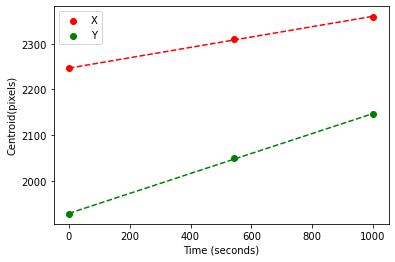

In [4]:
# Plot the drift and build a model of it
xs = []
ys = []
times = []
for i, expId in enumerate(expIds):
    if abs(positionData[expId]['hex_x']) < 0.001:
        times.append(positionData[expId]['Time'])
        xs.append(positionData[expId]['Centroid'][0])
        ys.append(positionData[expId]['Centroid'][1])
x_fit = np.polyfit(times, xs, 1)
y_fit = np.polyfit(times, ys, 1)
tplot = np.linspace(times[0], times[-1], 100)
xplot = x_fit[0] * tplot + x_fit[1]
yplot = y_fit[0] * tplot + y_fit[1]

plt.scatter(times, xs, color='red', label = 'X')
plt.scatter(times, ys, color='green', label = 'Y')
plt.plot(tplot, xplot, color='red', ls = '--')
plt.plot(tplot, yplot, color='green', ls = '--')
plt.xlabel("Time (seconds)")
plt.ylabel("Centroid(pixels)")
plt.legend()

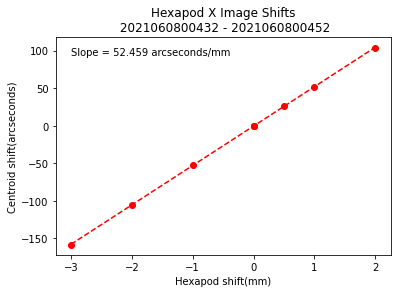

In [5]:
# Now plot the shift vs hexapod displacement
plateScale = exp.getWcs().getPixelScale().asArcseconds() # arcseconds/pixel
hexs = []
shifts = []
for i, expId in enumerate(expIds):
    hex = positionData[expId]['hex_x']
    hexs.append(hex)

    time = positionData[expId]['Time']
    x = positionData[expId]['Centroid'][0]
    y = positionData[expId]['Centroid'][1]
    # Subtract drift model
    x -= x_fit[0] * time + x_fit[1]
    y -= y_fit[0] * time + y_fit[1]
    if hex > 0:
        shifts.append(np.sqrt(x*x + y*y) * plateScale)
    else:
        shifts.append(-np.sqrt(x*x + y*y) * plateScale)
plt.title(f"Hexapod X Image Shifts\n {expIds[0]} - {expIds[-1]}")
plt.scatter(hexs, shifts, color='red')
shift_fit = np.polyfit(hexs, shifts, 1)
xplot = np.linspace(min(hexs), max(hexs), 100)
yplot = shift_fit[0] * xplot + shift_fit[1]
plt.plot(xplot, yplot, color='red', ls = '--')
plt.xlabel("Hexapod shift(mm)")
plt.ylabel("Centroid shift(arcseconds)")
plt.text(min(hexs), 0.9*max(shifts), f"Slope = {shift_fit[0]:.3f} arcseconds/mm")
plt.savefig("/home/craiglagegit/DATA/Hexapod_X_Offsets_11Jun21.pdf")

## Now repeat with Y shifts


In [6]:
expIds = [2021060800452, 2021060800453, 2021060800456, 2021060800459, \
          2021060800462, 2021060800465, 2021060800466, 2021060800469, 2021060800472]
hex_yoffset = [0.0, 0.5, 1.0, 2.0, 4.0, 0.0, -1.0, -2.0, 0.0]
positionData = {}

for i, expId in enumerate(expIds):
    data = {}
    data['hex_y'] = hex_yoffset[i]
    exp = butler.get('quickLookExp', detector=0, expId=expId)
    arr = exp.getMaskedImage().getArrays()[0]
    qm_config = QuickFrameMeasurementTask.ConfigClass()
    qm = QuickFrameMeasurementTask(config=qm_config)
    result = qm.run(exp)
    centroid = result.brightestObjCentroid
    data['Centroid'] = centroid
    mData = exp.getMetadata()
    date = mData['DATE']
    if i == 0:
        t0 = date
    time = TimeDelta(Time(date, scale='utc').jd, -Time(t0, scale='utc').jd).to_value('sec')
    data['Time'] = time
    positionData[expId] = data

Ignoring translator header fixup of LATISS AT_O_20210608_000452: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000453: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000456: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000459: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000462: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000465: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000466: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000469: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210608_000472: 'MJD-OBS not found'


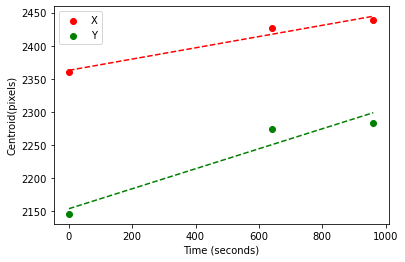

In [7]:
# Plot the drift and build a model of it
xs = []
ys = []
times = []
for i, expId in enumerate(expIds):
    if abs(positionData[expId]['hex_y']) < 0.001:
        times.append(positionData[expId]['Time'])
        xs.append(positionData[expId]['Centroid'][0])
        ys.append(positionData[expId]['Centroid'][1])
x_fit = np.polyfit(times, xs, 1)
y_fit = np.polyfit(times, ys, 1)
tplot = np.linspace(times[0], times[-1], 100)
xplot = x_fit[0] * tplot + x_fit[1]
yplot = y_fit[0] * tplot + y_fit[1]

plt.scatter(times, xs, color='red', label = 'X')
plt.scatter(times, ys, color='green', label = 'Y')
plt.plot(tplot, xplot, color='red', ls = '--')
plt.plot(tplot, yplot, color='green', ls = '--')
plt.xlabel("Time (seconds)")
plt.ylabel("Centroid(pixels)")
plt.legend()

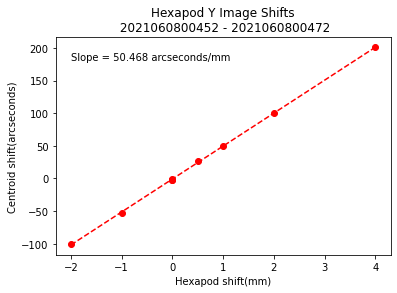

In [8]:
# Now plot the shift vs hexapod displacement
plateScale = exp.getWcs().getPixelScale().asArcseconds() # arcseconds/pixel
hexs = []
shifts = []
for i, expId in enumerate(expIds):
    hex = positionData[expId]['hex_y']
    hexs.append(hex)

    time = positionData[expId]['Time']
    x = positionData[expId]['Centroid'][0]
    y = positionData[expId]['Centroid'][1]
    # Subtract drift model
    x -= x_fit[0] * time + x_fit[1]
    y -= y_fit[0] * time + y_fit[1]
    if hex > 0:
        shifts.append(np.sqrt(x*x + y*y) * plateScale)
    else:
        shifts.append(-np.sqrt(x*x + y*y) * plateScale)
plt.title(f"Hexapod Y Image Shifts\n {expIds[0]} - {expIds[-1]}")
plt.scatter(hexs, shifts, color='red')
shift_fit = np.polyfit(hexs, shifts, 1)
xplot = np.linspace(min(hexs), max(hexs), 100)
yplot = shift_fit[0] * xplot + shift_fit[1]
plt.plot(xplot, yplot, color='red', ls = '--')
plt.xlabel("Hexapod shift(mm)")
plt.ylabel("Centroid shift(arcseconds)")
plt.text(min(hexs), 0.9*max(shifts), f"Slope = {shift_fit[0]:.3f} arcseconds/mm")
plt.savefig("/home/craiglagegit/DATA/Hexapod_Y_Offsets_11Jun21.pdf")

In [9]:
mData['ELSTART']

58.8748735769623